# Analyzing iMessage Conversations with GF

## Load chat data in sqlite

##### Load chat data from ~/username/Library/Messages/chat.db into sqlite to use the native macOS sqlite to open up the chat.db type: 

`sqlite3 /Users/username/Library/Messages/chat.db` 



#### Look into the tables with: 

`.tables`

Three sections: 
* extracting the data
* transforming (cleaning) the data
* getting insights into data 
** Messages I sent versus bridget

In [131]:
import sqlite3
import pandas as pd
import datetime
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot') # do i need this? 
sns.set_palette('Set2') # do i need this? 

In [132]:
# connect to sqlite chat database in user directory
sqlite_db = sqlite3.connect('/Users/adamstueckrath/Library/Messages/chat.db')

In [133]:
# get a “cursor” to execute sql commands
sql_command = sqlite_db.cursor()

In [134]:
# sql query -> need to expand and give description 
query = '''
        SELECT * FROM chat
        INNER JOIN handle
            ON chat.chat_identifier = handle.id
        INNER JOIN chat_handle_join
            ON  handle.ROWID = chat_handle_join.handle_id
        INNER JOIN message
            ON message.handle_id = chat_handle_join.handle_id
        WHERE (chat_identifier LIKE '%8385'
            OR chat_identifier LIKE '%622%')
            AND length(message.text) > 0
        '''

# execute sql query in sqlite3 
table = sql_command.execute(query)

# get list of column names. example: ['ROWID', 'account', 'account_guid']
# table.description is description of columns
column_names = list(map(lambda x: x[0], table.description))

# load sql table into pandas dataframe and pass in the column names
chat_df = pd.DataFrame(table.fetchall(), columns=column_names)

In [135]:
# List all of the tables in chat.db 

# Investigate data

#***MAKE NOTE OF STORED READ RECEIPTS "is_read"*** -> user expected behavior?? Maybe, maybe not?



In [136]:
# display iMessage chat dataframe head() 
chat_df.tail(2)

,ROWID,guid,style,state,account_id,properties,chat_identifier,service_name,room_name,account_login,...,associated_message_range_length,time_expressive_send_played,message_summary_info,ck_sync_state,ck_record_id,ck_record_change_tag,destination_caller_id,sr_ck_sync_state,sr_ck_record_id,sr_ck_record_change_tag
115164,3,iMessage;-;+12246228385,45,3,3AF46D92-D26E-4FE7-AAE0-12EB5480563D,b'bplist00\xd3\x01\x02\x03\x04\x05\x06_\x10\x1...,+12246228385,iMessage,None,E:stueckrath.adam@gmail.com,...,0,0,None,0,,,+15154180987,0,,
115165,3,iMessage;-;+12246228385,45,3,3AF46D92-D26E-4FE7-AAE0-12EB5480563D,b'bplist00\xd3\x01\x02\x03\x04\x05\x06_\x10\x1...,+12246228385,iMessage,None,E:stueckrath.adam@gmail.com,...,0,0,None,0,,,+15154180987,0,,


## Transform Data

In [137]:
# select columns from chat dataframe
column_list = ['id','is_from_me','text','cache_has_attachments','date']
chat_df = chat_df[column_list]

# show the last 5 rows with selected columns
chat_df.tail()

,id,is_from_me,text,cache_has_attachments,date
115161,+12246228385,0,And sex! Lots of sex!,0,545516764165205696
115162,+12246228385,1,Omg I can’t wait,0,545516776625032448
115163,+12246228385,1,Lol its fucking cold to get dry cleaning,0,545516784110073344
115164,+12246228385,1,👏🏻🤠🤡🎃🤖👽👹🤓🤩😏🧚🏻‍♂️👅😜,0,545531742114831936
115165,+12246228385,1,👏🏻🤠yo 🎃🤖👽👹HI Hello🤩😏🧚🏻‍♂️. 👅😜,0,545532006742589952


In [138]:
# house cleaning - drop duplicate columns from dataframe
chat_df = chat_df.loc[:,~chat_df.columns.duplicated()]

# rename columns 
chat_df.rename(columns={'id':'phone_number','is_from_me':'is_sent', 
                        'text':'message','cache_has_attachments':'is_picture', 
                        'date':'message_date'}, inplace=True)

# show the last 5 rows with selected columns
chat_df.tail()

,phone_number,is_sent,message,is_picture,message_date
115161,+12246228385,0,And sex! Lots of sex!,0,545516764165205696
115162,+12246228385,1,Omg I can’t wait,0,545516776625032448
115163,+12246228385,1,Lol its fucking cold to get dry cleaning,0,545516784110073344
115164,+12246228385,1,👏🏻🤠🤡🎃🤖👽👹🤓🤩😏🧚🏻‍♂️👅😜,0,545531742114831936
115165,+12246228385,1,👏🏻🤠yo 🎃🤖👽👹HI Hello🤩😏🧚🏻‍♂️. 👅😜,0,545532006742589952


In [139]:
# add column is_received column
# it is the opposite of is_sent. exmaple: is_sent = 1, is_received = 0
# axis=1 defines that function is to be applied on each row
chat_df['is_received'] = chat_df.apply(lambda row: int(not bool(row.is_sent)), axis=1)

In [140]:
# transform phone_number df.apply (lambda row: label_race (row),axis=1)
def clean_phone_numb(number):
    if bool(number):
        return '515-418-0987'
    return '224-622-8385'

chat_df['phone_number'] = chat_df.apply(lambda row: clean_phone_numb(row.is_sent), axis=1)


In [141]:
# transform message_date column into datetime.datetime object 
# convert numpy.int64 into pandas time ojbect 
# convert time object into datetime.datetime
chat_df['message_date'] = pd.to_datetime(chat_df['message_date'], unit='ns') 
chat_df['message_date'] = chat_df.apply(lambda row: row.message_date.to_pydatetime(warn=False),axis=1)
chat_df['message_date'] = chat_df.apply(lambda row: row.message_date + pd.DateOffset(years=30),axis=1)

chat_df.tail()


,phone_number,is_sent,message,is_picture,message_date,is_received
115161,224-622-8385,0,And sex! Lots of sex!,0,2017-04-15 20:26:04.165205,1
115162,515-418-0987,1,Omg I can’t wait,0,2017-04-15 20:26:16.625032,0
115163,515-418-0987,1,Lol its fucking cold to get dry cleaning,0,2017-04-15 20:26:24.110073,0
115164,515-418-0987,1,👏🏻🤠🤡🎃🤖👽👹🤓🤩😏🧚🏻‍♂️👅😜,0,2017-04-16 00:35:42.114831,0
115165,515-418-0987,1,👏🏻🤠yo 🎃🤖👽👹HI Hello🤩😏🧚🏻‍♂️. 👅😜,0,2017-04-16 00:40:06.742589,0


In [142]:
# add name column 
def add_name_col(phone_number):
    if phone_number == '515-418-0987':
        return 'Adam'
    return 'Bridget'

chat_df['name'] = chat_df.apply(lambda row: add_name_col(row.phone_number), axis=1)

## Data Visualization

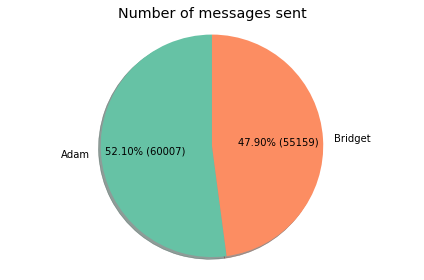

In [143]:
# pie chart for the number of messages sent between us
labels = ['Adam', 'Bridget']
values = [chat_df['is_sent'].value_counts()[1], 
         chat_df['is_received'].value_counts()[1]]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots()
ax1.set_title('Number of messages sent')
ax1.pie(values, labels=labels, autopct=make_autopct(values), shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

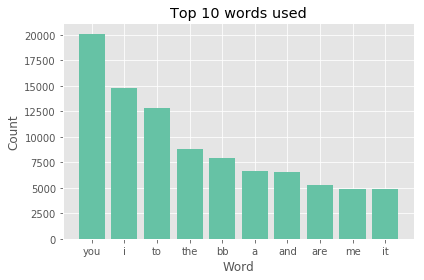

In [144]:
# get counts of every word using .lower() 
word_counts = chat_df.message.str.lower().str.split(expand=True).stack().value_counts()
word_count_df = word_counts.to_frame().reset_index()
word_count_df.rename(columns={'index':'word',0:'count'}, inplace=True)
word_count_df.sort_values('count', ascending=False, inplace=True)

# need to drop the count for spaces (' ') --> it's actually for pictures!! need to re-work logic
word_count_df.drop(df.index[[8]], inplace=True)
word_count_df.reset_index(drop=True, inplace=True)

# this is for plotting
# bar chart for top 10 words sent between us
bar_values = word_count_df[:10]
labels = bar_values['word'].values.tolist()
values = bar_values['count'].values.tolist()
x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, values)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 10 words used')
plt.xticks(x_pos, labels)
plt.tight_layout()
plt.show()

In [308]:
# here for decoding/encoding issues
#def changeencode(data, cols):
#    for col in cols:
#        data[col] = data[col].str.decode('iso-8859-1').str.encode('utf-8')
#    return data 

# Dictionary storing emoji counts 
import collections
emoji_count = collections.defaultdict(int) 
for i in chat_df['message']:
    for emoji in re.findall(r'[\U0001f300-\U0001f650]|[\u2000-\u3000]|[\U0001f3fb-\U0001f3ff]?|[1F4AA]', i):     
        emoji_count[emoji] += 1
adam_test = sorted(emoji_count.items(), key=lambda x: x[1], reverse=True)
print(adam_test)
print(len(adam_test))
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)


#char_with_modifier = re.compile(r'(.[\U0001f3fb-\U0001f3ff]?)')
#print (collections.Counter(char_with_modifier.findall(emoji_string)))


print(r'---------------------')
test = chat_df.iloc[[115165]]
test = test.values.tolist()[0]
test = test[2]
print(type(test),test)
print(r'---------------------')

print(r'---------------------')


#testing = [find_emoji(i) for i in test]
#print(len(testing),testing)

#word_count_df.loc[word_count_df['word'].isin(some_values)]

# get top day and number of messages
# get total # of words, and messages 

[('', 2311545), ('😭', 23892), ('’', 9192), ('🏻', 1368), ('🍕', 720), ('🖕', 692), ('😂', 468), ('😿', 460), ('😘', 392), ('😏', 256), ('😔', 252), ('💩', 244), ('👀', 224), ('😢', 224), ('“', 220), ('\u200d', 208), ('🙄', 200), ('”', 200), ('😈', 184), ('👹', 160), ('😍', 160), ('😫', 116), ('☺', 116), ('🙊', 112), ('🍰', 112), ('😑', 108), ('😽', 108), ('😩', 104), ('😟', 104), ('♂', 100), ('🙌', 97), ('👋', 92), ('😬', 92), ('😋', 88), ('😚', 84), ('☹', 84), ('😥', 76), ('😁', 68), ('♀', 64), ('🙈', 60), ('🍑', 60), ('😞', 56), ('🔪', 52), ('🍆', 52), ('💁', 52), ('👅', 52), ('🙁', 52), ('🏾', 48), ('🙏', 48), ('😶', 44), ('👏', 44), ('🔥', 44), ('😎', 44), ('😣', 40), ('😠', 40), ('👌', 40), ('😤', 40), ('👁', 40), ('😹', 36), ('😪', 36), ('🍻', 36), ('😡', 36), ('😝', 36), ('😉', 36), ('😖', 36), ('😅', 36), ('😀', 36), ('😊', 32), ('💦', 32), ('🙃', 32), ('😳', 32), ('👍', 32), ('🐶', 32), ('😃', 28), ('👺', 28), ('💉', 28), ('🎃', 28), ('🔫', 28), ('😴', 24), ('👎', 24), ('🍩', 24), ('😐', 24), ('🏳', 20), ('🌈', 20), ('🏃', 20), ('🏼', 20), ('💕', 20), 

In [252]:
# get top day and number of messages

# get total # of words, and messages 